In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import pickle
import matplotlib.pyplot as plt
from scipy.spatial import distance
from sklearn.metrics.pairwise import euclidean_distances
%matplotlib inline
import seaborn as sns

In [2]:
df_event_hosts = pd.read_pickle('df_event_hosts')
df_events = pd.read_pickle('df_events').set_index('id')
df_rsvps = pd.read_pickle('df_rsvps').set_index('rsvp_id')
df_group_topics = pd.read_pickle('df_group_topics')
df_venues = pd.read_pickle('df_venues')

# remove entry if there is no event_host_member_id
df_event_hosts = df_event_hosts.loc[df_event_hosts.event_hosts.notnull(),:]
df_event_hosts = df_event_hosts.rename(columns = {'event_hosts': 'member_id', 'id': 'event_id'})

#
df_venues = df_venues.rename(columns = {'id': 'venue_id', 'event_id':'id'})
df_venues = df_venues.set_index('id')

In [3]:
# map event_id and member_id
with open('group_url_topic_map.pkl', 'rb') as f:
    group_url_topic_map = pickle.load(f)
with open('group_id_topic_map.pkl', 'rb') as f:
    group_id_topic_map = pickle.load(f)

df_rsvps['topic'] = df_rsvps['group_urlname'].map(group_url_topic_map)
df_events['topic'] = df_events['group_urlname'].map(group_url_topic_map)
map_dicts = df_events.loc[:,['group_urlname', 'topic']].to_dict()
df_event_hosts['topic'] = df_event_hosts['event_id'].map(map_dicts['topic'])
df_group_topics['topic_category'] = df_group_topics['id'].map(group_id_topic_map)

# only examine topics with more than 1000 events
event_cutoffN = 1000
eventN = df_events.topic.value_counts(ascending=False)
selected_topics = eventN.loc[eventN > event_cutoffN].index
topicN = len(selected_topics)

# rename topics with simpler names 
renamed_topics = ['social', 'tech', 'career', 'outdoors',
       'sports', 'language', 'games', 'singles', 'beliefs',
       'health', 'food', 'movements', 'music', 'dancing',
       'photo', 'film', 'book', 'arts']
rename_libarary = {before : after for before, after in zip(selected_topics, renamed_topics) if before is not after}

In [4]:
# the number of events in each topic category 
topic_N = eventN[:topicN].to_dict()
for old_key, new_key in zip(selected_topics, renamed_topics):
    if old_key is not new_key:
        topic_N[new_key] = topic_N.pop(old_key)

In [5]:
# core data
def prepare_data(df, group1, group2, count):
    df_new = df.groupby([group1, group2])[count].count().unstack().fillna(0)
    df_new = df_new.loc[:,selected_topics]
    df_new = df_new.rename(columns = rename_libarary)
    return df_new

# the number of rsvps or hosts for each topic
rsvp_topic = prepare_data(df_rsvps, 'member_id', 'topic', 'event_id')
host_topic = prepare_data(df_event_hosts, 'member_id', 'topic', 'event_id')
group_topic = prepare_data(df_group_topics, 'topics', 'topic_category', 'id') 


In [6]:
from itertools import combinations
from itertools import product
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity

# generate generalized Jaccard index
def generalized_JACCARD(df):
    # jaccard index matrix initialization
    column_N = len(df.columns)
    iu = np.triu_indices(column_N, 1)
    jaccard_index_matrix = np.zeros(column_N ** 2).reshape(column_N, column_N)
    # run pair-wise jaccard similarity
    jaccard_indicies = []
    for pair in combinations(df.columns, 2):
        df_pair = df.loc[:,[pair[0], pair[1]]]
        pair_index = df_pair.min(axis = 1).sum()/df_pair.max(axis = 1).sum()
        jaccard_indicies.append(pair_index)
    # transfer to matrix 
    jaccard_index_matrix[iu] = jaccard_indicies
    jaccard_index_matrix += jaccard_index_matrix.T
    return jaccard_index_matrix

def association_strength(df, cut_off = 0):
    column_N = len(df.columns)
    df = df > cut_off
    iu = np.triu_indices(column_N, 1)
    association_strength_matrix = np.zeros(column_N ** 2).reshape(column_N, column_N)
    # run pair-wise jaccard similarity
    association_strengths = []
    for pair in combinations(df.columns, 2):
        pair_index = sum(df.loc[:,pair[0]] & df.loc[:,pair[1]])/(sum(df.loc[:,pair[0]]) * sum(df.loc[:,pair[1]]))
        association_strengths.append(pair_index)
    association_strength_matrix[iu] = association_strengths
    association_strength_matrix += association_strength_matrix.T
    return association_strength_matrix
    

# display similarity matrix among topics with different measures of similarity 
def get_similarity_matrix(df, method, plot=True):
    if method == 'cosine':
        rsm = cosine_similarity(df.T)
        rsm[np.diag_indices_from(rsm)] = 0.
    elif method == 'jaccard':
        rsm = 1 - pairwise_distances((df>0).T, metric = 'jaccard')
        rsm[np.diag_indices_from(rsm)] = 0.
    elif method == 'g_jaccard':
        rsm = generalized_JACCARD(df)
    elif method == 'association':
        rsm = association_strength(df)
    
    if plot:
        plt.yticks(list(range(len(df.columns))), list(df.columns));
        plt.xticks(list(range(len(df.columns))), list(df.columns), rotation = 90)
        plt.imshow(rsm, cmap = 'Reds')
        return plt,rsm
    else:
        return rsm
    


In [43]:
# get normalized edge widths
def get_edge_widths(edge_indicies, unit_width):
    ind_base = min(edge_indicies)
    ind_range = max(edge_indicies) - ind_base
    edge_widths = [(ind - ind_base) * (unit_width *0.9) / ind_range + (unit_width *0.1) for ind in edge_indicies]
    return edge_widths
    
# draw 
def get_edges(similarity_matrix, var_names, cut_off_q):
    shp,l = similarity_matrix.shape, len(var_names)
    try:
        if not ((shp[0] == shp[1]) & (shp[0] == l)):
            raise Exception
        iu = np.triu_indices(l, 1)
        dat = similarity_matrix[iu]
        cut_off_val = np.percentile(dat, cut_off_q)     
        edge_list, edge_indicies = [], []
        for ind, edg in zip(dat, combinations(var_names, 2)):
            if ind > cut_off_val:
                edge_list.append(edg)
                edge_indicies.append(ind)
        edge_widths = get_edge_widths(edge_indicies, 0.5)
        return edge_list, edge_widths
    except Exception as e:
        print('error')

# draw networks of topic categories
def draw_networks(similarity_matrix, var_names, cut_off_q = 80):
    edge_list, edge_widths = get_edges(similarity_matrix, renamed_topics, cut_off_q)
    # generate network
    G = nx.from_edgelist(edge_list)
    #print(G.number_of_edges(1))
    pos = nx.spring_layout(G)
    # node size: relational to the counts of topics
    node_size_list = [topic_N[key]/10 for key in pos.keys()]
    # node color: relational to the degrees of topics
    node_color_list = [val/10 for val in list(dict(G.degree).values())]
    # draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=node_size_list, node_color = node_color_list, 
                           cmap='Reds', linewidths=1, edgecolors='k')
    # draw edges
    for edg, ind in zip(edge_list, edge_widths):
        nx.draw_networkx_edges(G, pos, edgelist=[edg], width=ind*5, alpha = 0.5)
    # draw labels
    for p,ns in zip(pos, node_size_list):  # raise text positions
        pos[p][1] += 0.07 + (np.sqrt(ns) - 10)*0.0015
    nx.draw_networkx_labels(G, pos, font_size = 12)
    plt.axis('off')
    return plt



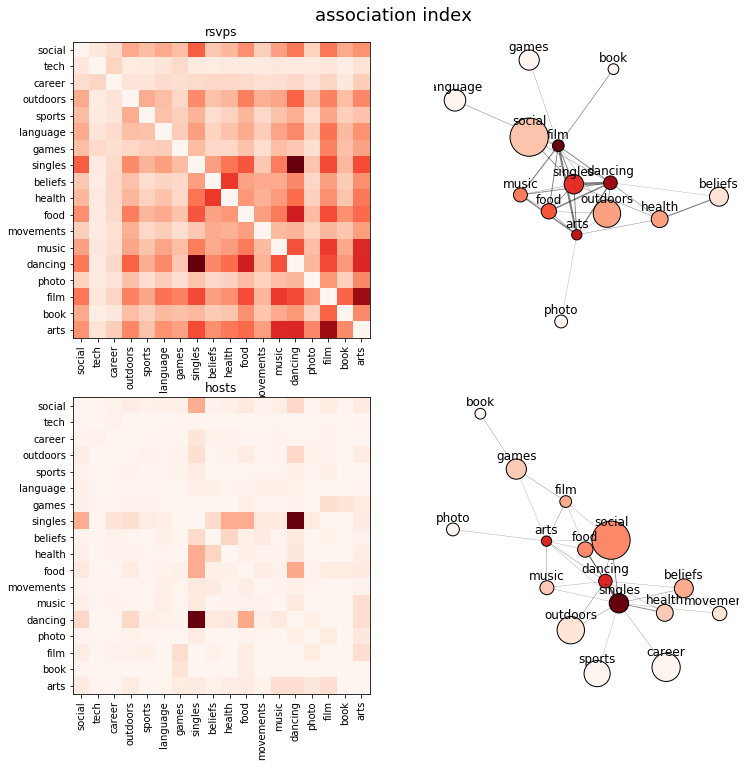

In [44]:
method = 'association'
data_set = (rsvp_topic, host_topic)
data_name = ['rsvps', 'hosts']


subplot_size, fig_row, fig_col = 6, 2, len(data_set)
fig,axes = plt.subplots(figsize=(subplot_size*fig_col, subplot_size*fig_row))
for rowI,data in enumerate(data_set):
    plt.subplot(fig_row, fig_col, rowI*2 + 1)
    plt, rsm = get_similarity_matrix(data, method)
    plt.title(data_name[rowI])

    plt.subplot(fig_row, fig_col, rowI*2 + 2)
    draw_networks(rsm, renamed_topics, cut_off_q=80)

plt.suptitle(f'{method} index', y = 0.92, fontsize = 18)
plt.show()


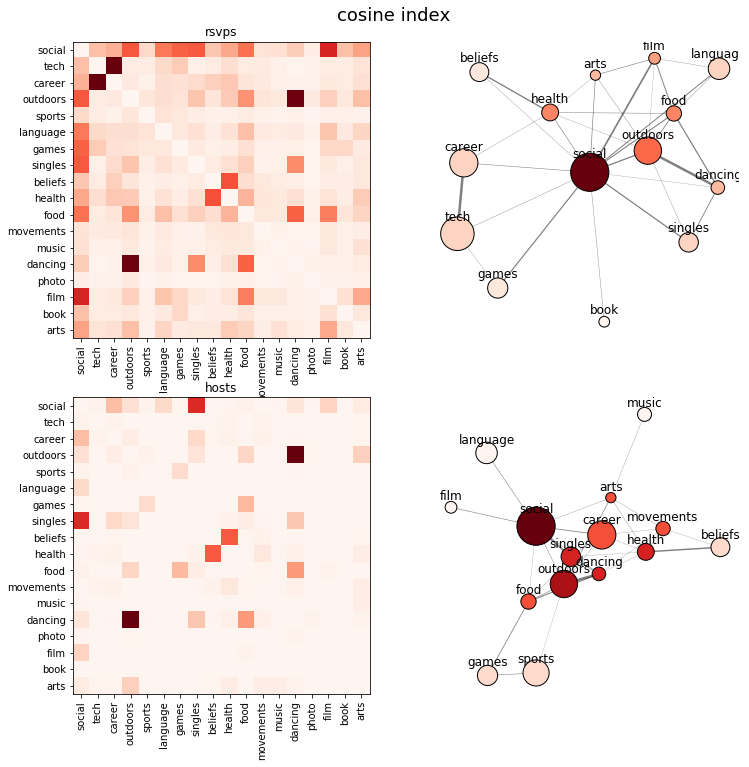

In [45]:
method = 'cosine'
data_set = (rsvp_topic, host_topic)
data_name = ['rsvps', 'hosts']


subplot_size, fig_row, fig_col = 6, 2, len(data_set)
fig,axes = plt.subplots(figsize=(subplot_size*fig_col, subplot_size*fig_row))
for rowI,data in enumerate(data_set):
    plt.subplot(fig_row, fig_col, rowI*2 + 1)
    plt, rsm = get_similarity_matrix(data, method)
    plt.title(data_name[rowI])

    plt.subplot(fig_row, fig_col, rowI*2 + 2)
    draw_networks(rsm, renamed_topics, cut_off_q=80)

plt.suptitle(f'{method} index', y = 0.92, fontsize = 18)
plt.show()

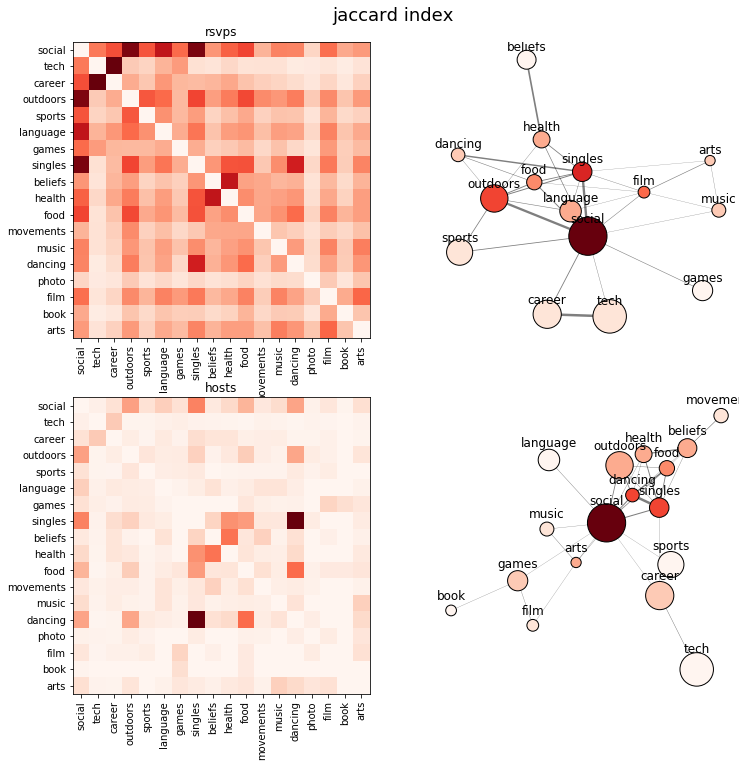

In [46]:
method = 'jaccard'
data_set = (rsvp_topic, host_topic)
data_name = ['rsvps', 'hosts']


subplot_size, fig_row, fig_col = 6, 2, len(data_set)
fig,axes = plt.subplots(figsize=(subplot_size*fig_col, subplot_size*fig_row))
for rowI,data in enumerate(data_set):
    plt.subplot(fig_row, fig_col, rowI*2 + 1)
    plt, rsm = get_similarity_matrix(data, method)
    plt.title(data_name[rowI])

    plt.subplot(fig_row, fig_col, rowI*2 + 2)
    draw_networks(rsm, renamed_topics, cut_off_q=80)

plt.suptitle(f'{method} index', y = 0.92, fontsize = 18)
plt.show()